This is a copy of the notebook `3VAE.ipynb` using hidden_dim=5 instead of three to facilitate plotting and add another baseline for the excess return regressions.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm
from sklearn.decomposition import PCA
from utils.plotting_utils import plot_marginal_r_squares
from utils.data_utils import load_yield_data, load_fred_md
from utils.seed_utils import set_random_seed
from utils.plotting_utils import plot_latent_space_trajectory_3d_static

from utils.VanillaVAE import VanillaVAE1D
set_random_seed(1)

yield_data = load_yield_data()
FIRST_DATE = yield_data.index.min() - pd.DateOffset(months=1)
LAST_DATE = yield_data.index.max()

# Model and training loop

In [2]:
def analyticalPCA(y, dimension):
    pca = PCA(n_components=dimension)
    pca.fit(y)
    return pca.components_, pca.transform(y)

# Prepare data
y = yield_data.values.astype('float32')
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
y_normalized = (y - y_mean) / y_std

# Convert to PyTorch tensors
# Shape: (n_samples, 1, 120) - add channel dimension for Conv1D
y_tensor = torch.FloatTensor(y_normalized).unsqueeze(1)

# Create DataLoader
batch_size = 32
dataset = TensorDataset(y_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f"Using device: {device}")

vae = VanillaVAE1D(
    in_channels=1,
    seq_length=120,
    latent_dim=5,
    hidden_dims=[32, 64, 128]
).to(device)

# Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training parameters
kld_weight = 0.00025  # Beta parameter (lower = less regularization)

# --- ANNEALING PARAMETERS ---
num_epochs = 50
# 1. Warm-up Phase: KLD weight is 0 for the first 10 epochs.
anneal_start_epoch = 10
# 2. Annealing Phase: KLD weight linearly increases over the next 20 epochs.
anneal_duration = 20
# 3. Final Phase: KLD weight stays at its final value for the rest of training.
start_beta = 0.0
end_beta = 0.0025

# Storage for losses
train_losses = {
    'total': [],
    'reconstruction': [],
    'kld': []
}

Using device: cuda


In [ ]:
# Training loop
for epoch in range(num_epochs):
    vae.train()
    epoch_losses = {
        'total': 0.0,
        'reconstruction': 0.0,
        'kld': 0.0
    }
    
    # --- DYNAMIC KLD WEIGHT CALCULATION ---
    if epoch < anneal_start_epoch:
        kld_weight = start_beta
    elif epoch < anneal_start_epoch + anneal_duration:
        progress = (epoch - anneal_start_epoch) / anneal_duration
        kld_weight = start_beta + (end_beta - start_beta) * progress
    else:
        kld_weight = end_beta
    # ---------------------------------------    

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, (data,) in enumerate(pbar):
        data = data.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        recons, input, mu, log_var = vae(data)
        
        # Calculate loss
        loss_dict = vae.loss_function(
            recons, input, mu, log_var,
            kld_weight=kld_weight
        )
        
        # Backward pass
        loss = loss_dict['loss']
        loss.backward()
                
        # Update weights
        optimizer.step()
        
        # Accumulate losses
        epoch_losses['total'] += loss.item()
        epoch_losses['reconstruction'] += loss_dict['Reconstruction_Loss'].item()
        epoch_losses['kld'] += loss_dict['KLD'].item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'recon': f"{loss_dict['Reconstruction_Loss'].item():.4f}",
            'kld': f"{loss_dict['KLD'].item():.4f}"
        })
    
    # Average losses for epoch
    num_batches = len(train_loader)
    epoch_losses = {k: v / num_batches for k, v in epoch_losses.items()}
    
    # Store losses
    train_losses['total'].append(epoch_losses['total'])
    train_losses['reconstruction'].append(epoch_losses['reconstruction'])
    train_losses['kld'].append(epoch_losses['kld'])
    
    # Print epoch summary
    if (epoch + 1) % 10 == 0:
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Total Loss: {epoch_losses['total']:.4f}")
        print(f"  Reconstruction: {epoch_losses['reconstruction']:.4f}")
        print(f"  KLD: {epoch_losses['kld']:.4f}")
        print("-"*60)

# Reconstruction quality

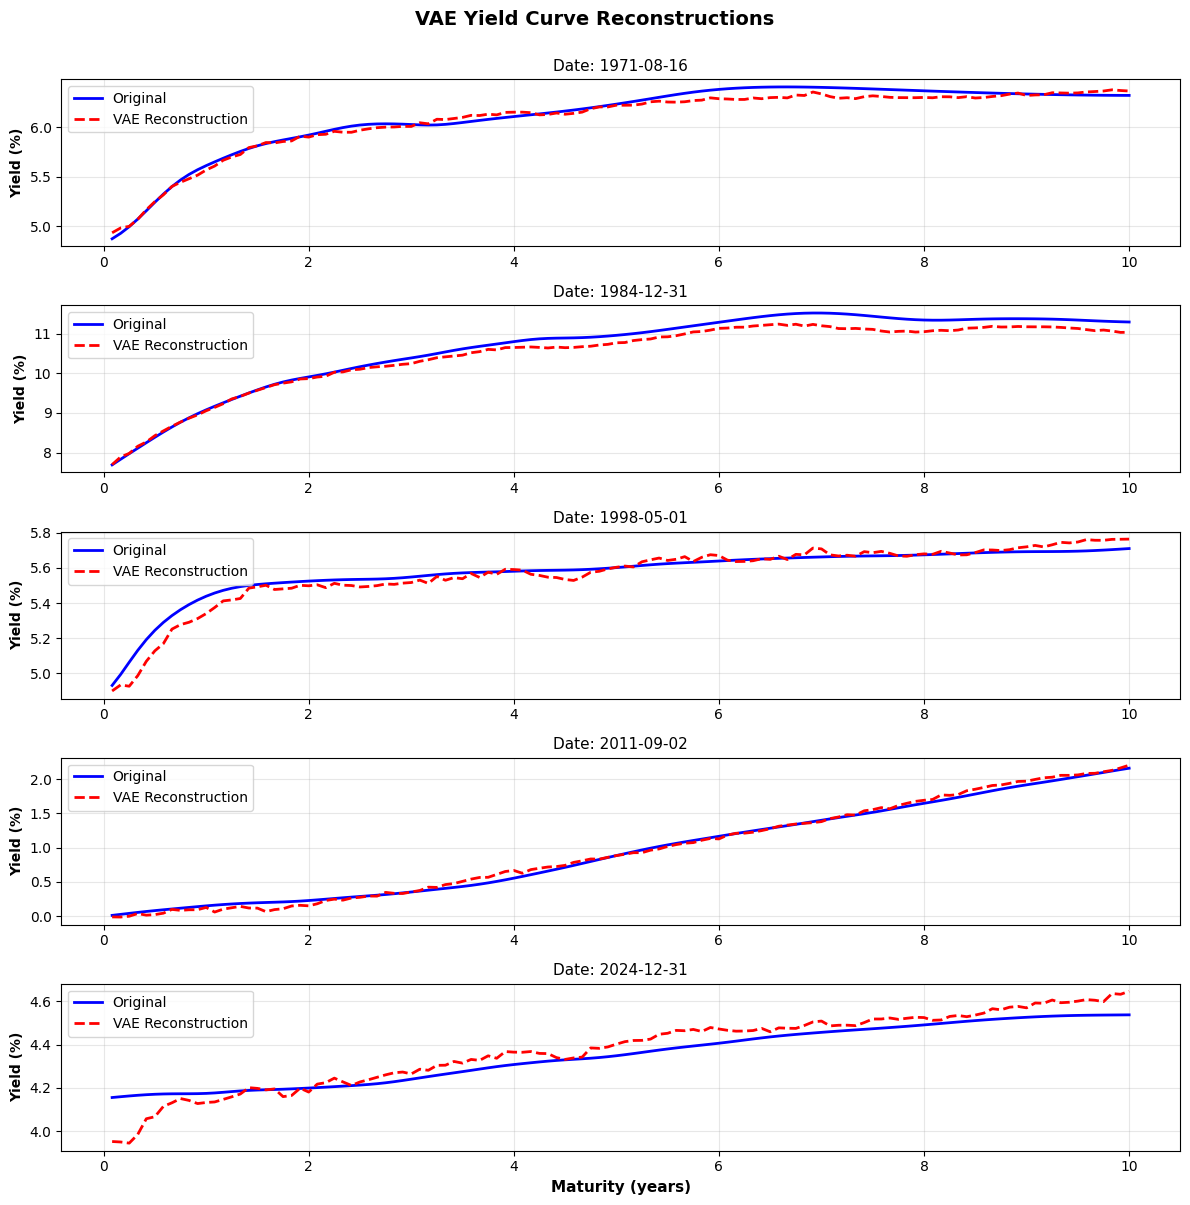

In [4]:
# Extract latent factors from VAE
vae.eval()
with torch.no_grad():
    y_tensor_full = torch.FloatTensor(y_normalized).unsqueeze(1).to(device)
    mu, log_var = vae.encode(y_tensor_full)
    
    vae_scores = mu.cpu().numpy()
    vae_std = torch.exp(0.5 * log_var).cpu().numpy()

vae_scores_df = pd.DataFrame(
    vae_scores,
    index=yield_data.index,
    columns=['C5', 'C4', 'C3', 'C2', 'C1']
)

# Write VAE 2D scores to csv
vae_scores_df.to_csv(r'scores/vae5D_scores.csv')

vae.eval()
with torch.no_grad():
    recons, _, _, _ = vae(y_tensor_full)
    recons = recons.cpu().numpy().squeeze()

# Denormalize
recons_denorm = recons * y_std + y_mean
y_original = y

# Plot some reconstructions
n_examples = 5
indices = np.linspace(0, len(y)-1, n_examples, dtype=int)

maturities_years = np.arange(1, 121) / 12

fig, axes = plt.subplots(n_examples, 1, figsize=(12, 12))

for idx, ax in zip(indices, axes):
    date = yield_data.index[idx]
    ax.plot(maturities_years, y_original[idx], 'b-', linewidth=2, label='Original')
    ax.plot(maturities_years, recons_denorm[idx], 'r--', linewidth=2, label='VAE Reconstruction')
    ax.set_ylabel('Yield (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'Date: {date.strftime("%Y-%m-%d")}', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Maturity (years)', fontsize=11, fontweight='bold')
plt.suptitle('VAE Yield Curve Reconstructions', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

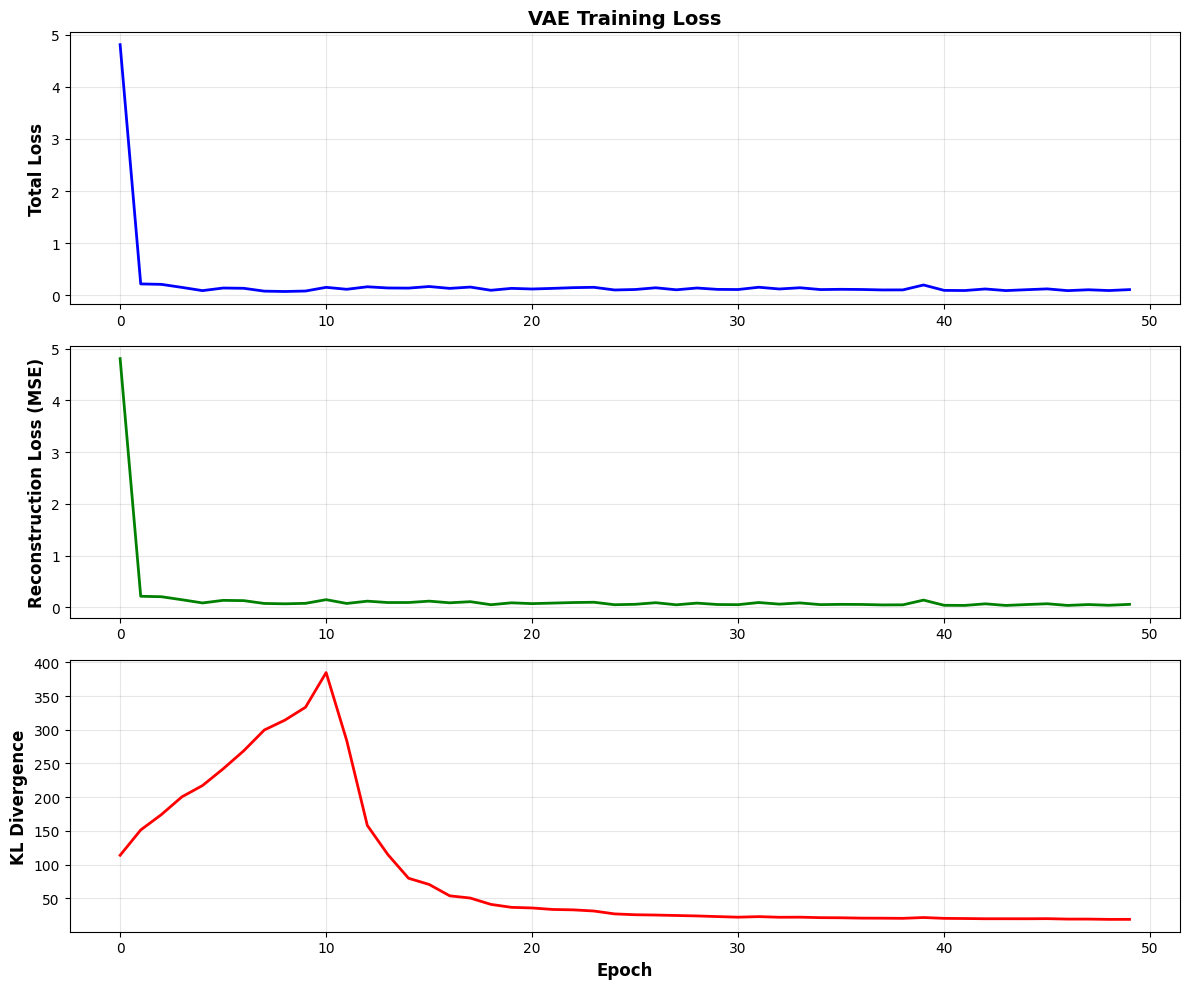


Final Training Metrics:
Total Loss: 0.107177
Reconstruction Loss: 0.060543


In [5]:
# Plot training losses
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Total loss
axes[0].plot(train_losses['total'], linewidth=2, color='blue')
axes[0].set_ylabel('Total Loss', fontsize=12, fontweight='bold')
axes[0].set_title('VAE Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(train_losses['reconstruction'], linewidth=2, color='green')
axes[1].set_ylabel('Reconstruction Loss (MSE)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# KLD loss
axes[2].plot(train_losses['kld'], linewidth=2, color='red')
axes[2].set_ylabel('KL Divergence', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"Total Loss: {train_losses['total'][-1]:.6f}")
print(f"Reconstruction Loss: {train_losses['reconstruction'][-1]:.6f}")